In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import math
import re
import plotly.express as px
import statsmodels.api as sm

from sqlalchemy import create_engine
import psycopg2

In [11]:
train = pd.read_csv('data/train.csv')
train['date'] = pd.to_datetime(train['date'])
train.sort_values(['date','city'],inplace=True)
train['date_day'] = train['date'].dt.day_of_year
train['date_month'] = train['date'].dt.month
x = train[['date_day','pm2_5']].groupby('date_day').aggregate('mean')


In [19]:
city_list = train['city'].unique()
country_list =  train['country'].unique()
print(city_list)
print(country_list)


['Kampala' 'Nairobi' 'Lagos' 'Bujumbura']
['Uganda' 'Kenya' 'Nigeria' 'Burundi']


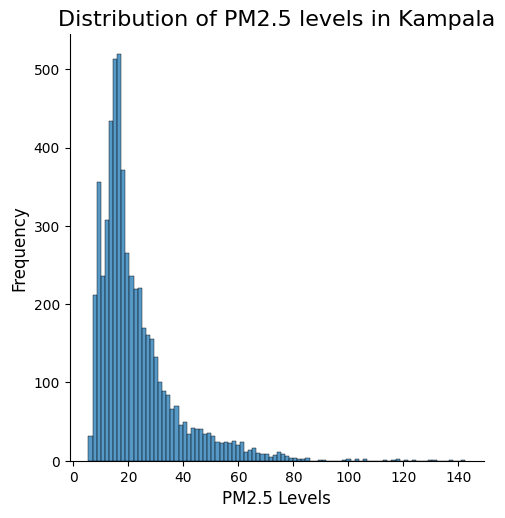

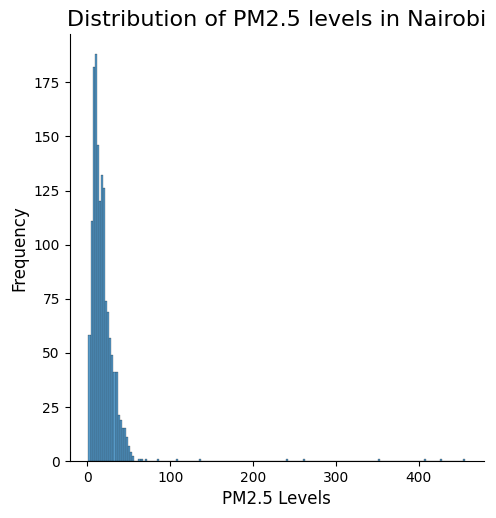

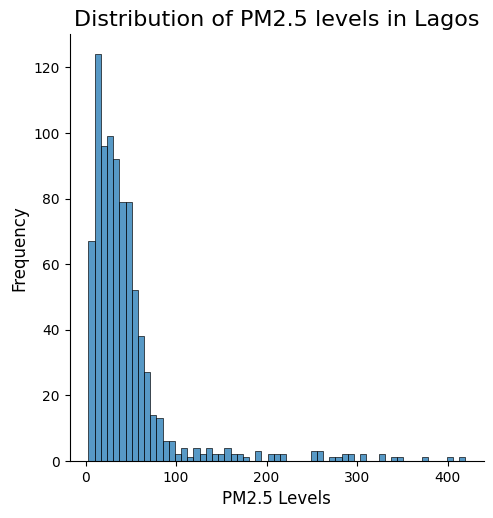

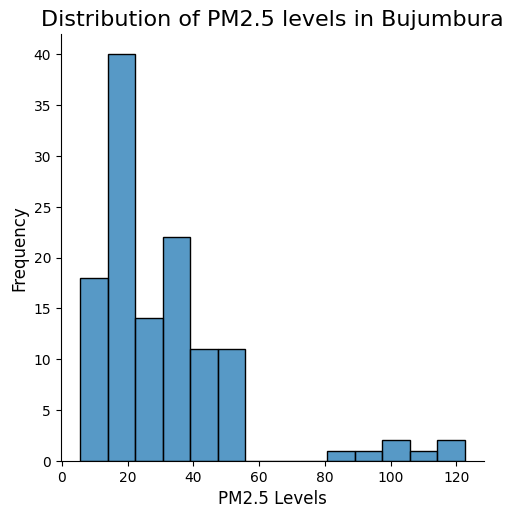

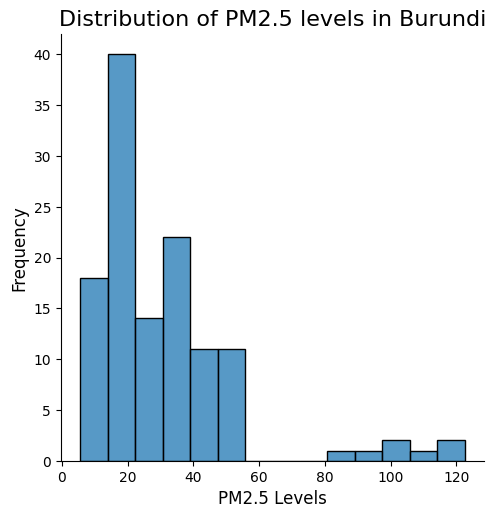

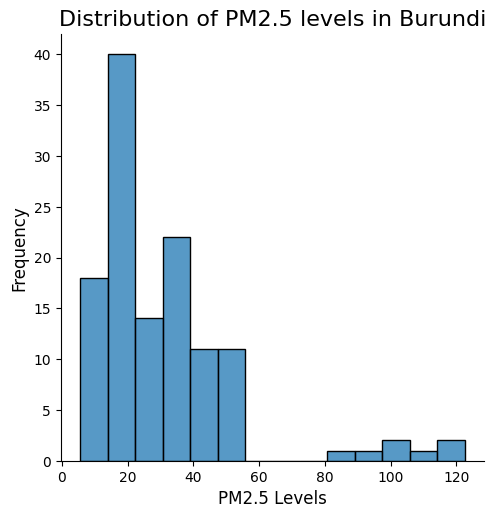

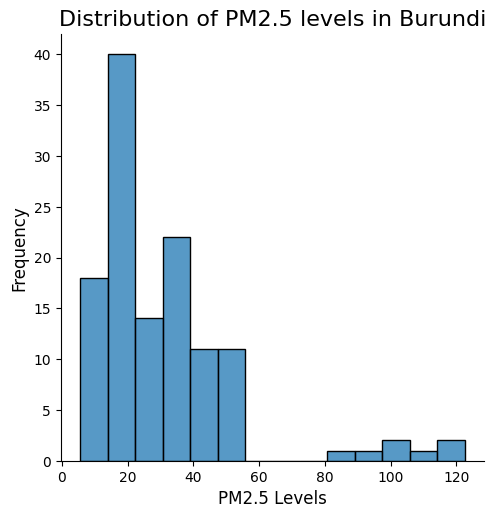

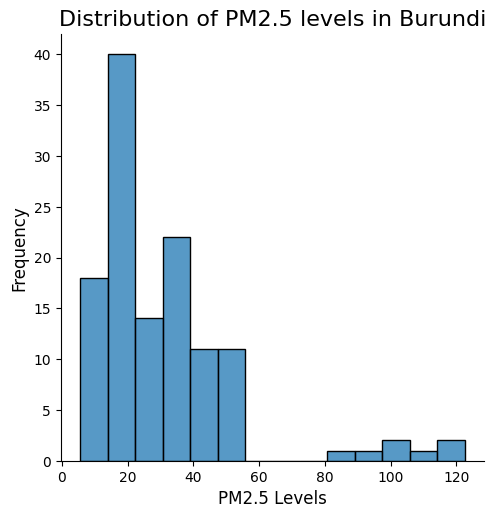

In [25]:
train[train['city']==city_list[0]]['pm2_5']
for i in range(0,len(city_list)):
    sns.displot(train[train['city']==city_list[i]]['pm2_5'])
    plt.title(f'Distribution of PM2.5 levels in {city_list[i]}', fontsize=16)
    plt.xlabel('PM2.5 Levels', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
for j in range(0,len(country_list)):
     sns.displot(train[train['city']==city_list[i]]['pm2_5'])
     plt.title(f'Distribution of PM2.5 levels in {country_list[i]}', fontsize=16)
     plt.xlabel('PM2.5 Levels', fontsize=12)
     plt.ylabel('Frequency', fontsize=12)

<Axes: xlabel='date_day', ylabel='pm2_5'>

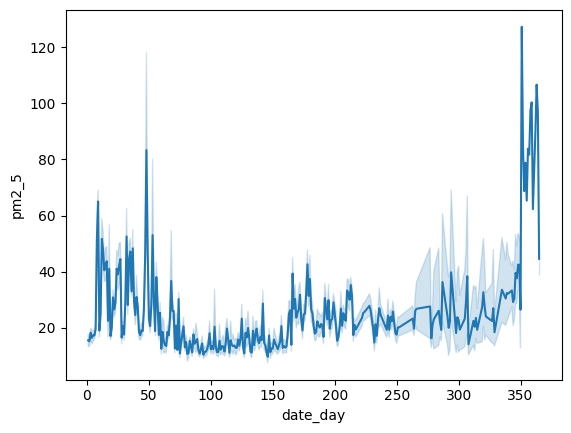

In [26]:
sns.lineplot(y=train['pm2_5'],x=train['date_day'])

<Axes: xlabel='date_day', ylabel='pm2_5'>

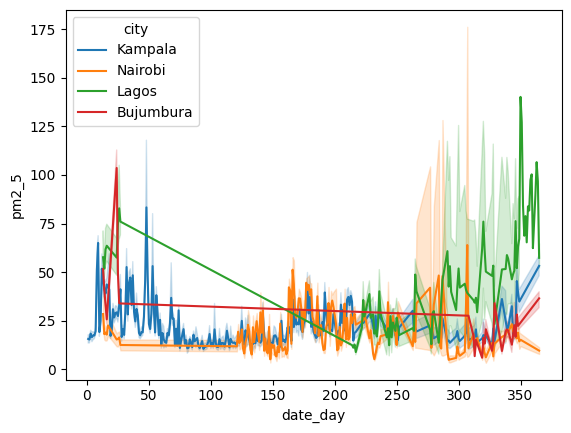

In [27]:
sns.lineplot(y=train['pm2_5'],x=train['date_day'],hue=train['city'])

<Axes: xlabel='date_day', ylabel='pm2_5'>

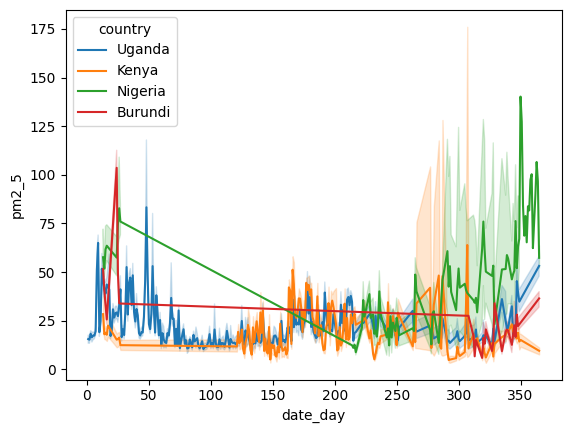

In [28]:
sns.lineplot(y=train['pm2_5'],x=train['date_day'],hue=train['country'])

<Axes: xlabel='date', ylabel='pm2_5'>

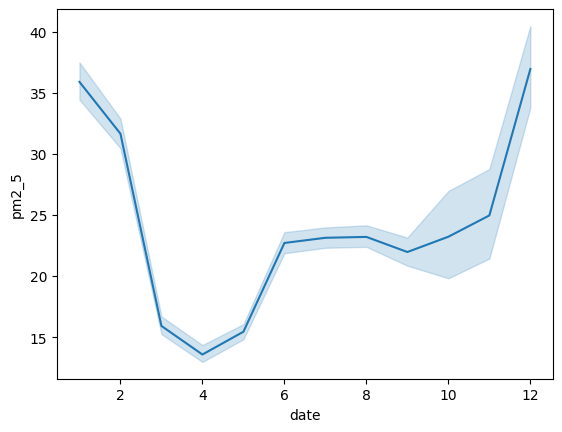

In [29]:
sns.lineplot(x=train['date'].dt.month,y=train['pm2_5'])

<Axes: xlabel='date', ylabel='pm2_5'>

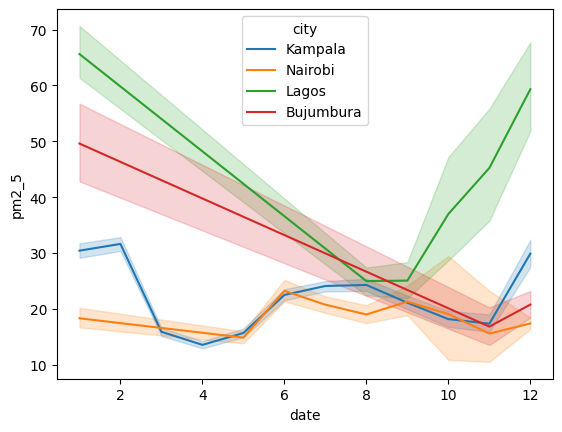

In [30]:
sns.lineplot(x=train['date'].dt.month,y=train['pm2_5'],hue=train['city'])

<Axes: xlabel='hour', ylabel='pm2_5'>

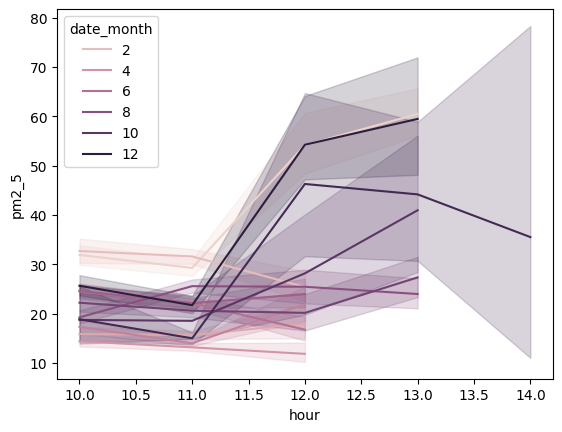

In [31]:
sns.lineplot(x=train['hour'],y=train['pm2_5'],hue=train['date_month'])

<Axes: xlabel='date', ylabel='pm2_5'>

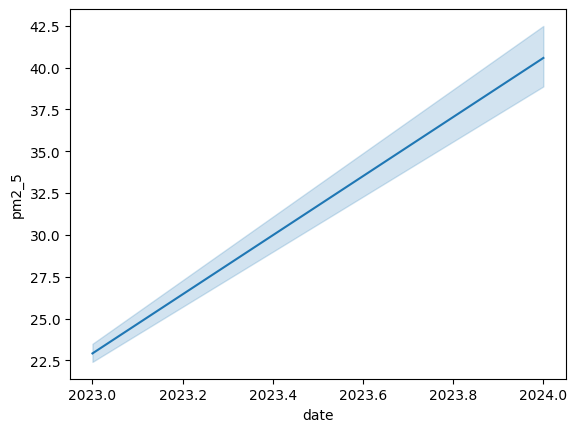

In [35]:
sns.lineplot(x=train['date'].dt.year,y=train['pm2_5'])

<Axes: xlabel='site_latitude', ylabel='site_longitude'>

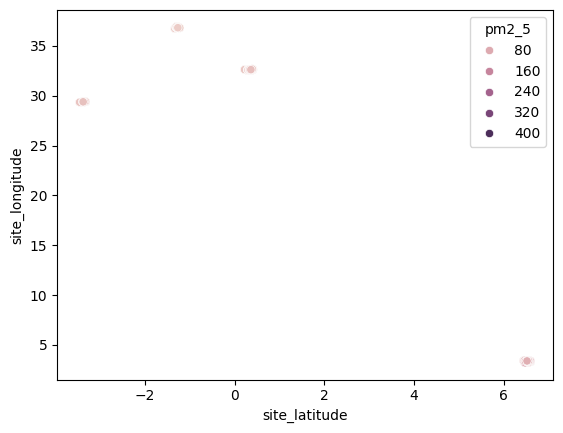

In [36]:
sns.scatterplot(x=train['site_latitude'],y=train['site_longitude'],hue=train['pm2_5'])

In [ ]:
traintest = pd.concat([train,test])
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])
top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending = False).tail(10)
# top10_corrs += top10_corrs + train['pm2_5']
corr = train_num_df[list(top10_corrs.index)].corr()
seaborn.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 15})
plt.show()